# Fairness Monitoring
This notebook explains how to use the findhr API to monitor the fairness of a candidate pool.

In [1]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../../src"))
sys.path.append(project_root)

In [2]:
from findhr.monitoring import *

2025-04-24 18:02:19,257 Install package gmpy2 for better performance.


## Protocol Stage 1: Candidate application + redirection to optional attribute donation

This step will be implemented by the service provider. See the documentation for more details.

## Protocol Stage 2: Optional attribute donation

Choose either method A (Third-party-mediated attribute distribution in backend) or method B (Front-end-supported attribute distribution) to deposit encrypted data in the two parties. See the documentation for more details.

### Method A: Third-party-mediated attribute distribution

In [3]:
# The third party can create their own data handling class inheriting from MultipartyDataCollection
# The class needs to override two functions for handling the storage of secret data locally, as well as sending it to the server

class SecretDataHandler(MultipartyDataCollection):

    def send_to_model_owner(self, provider_id, user_id, attribute_name, secret_protected_attribute):
        pass

    def store(self, provider_id, user_id, attribute_name, secret_protected_attribute):
        pass


# For the purpose of this demonstration, however, we're going to use an example implementation that uses CSV files for storing data locally

# Replace with your own files if you wish.
# These files will be overwritten with new example data after running this notebook.
filename_third_party = '../../../data/risk_monitoring/third_party_local_data.csv'
filename_service_provider = '../../../data/risk_monitoring/service_provider_remote_data.csv'

In [4]:
# When the user wants to donate the attribute, we need to:
# (1) generate multi-party components from the value of the attribute, 
# (2) store the local component
# (3) send the Model Owner component to them

# Model owner authenticates themselves with an ID, e.g., an API key 
# (the exact form of this identifier will depend on the third party implementation)
# How to safely authenticate will be determined when we build project demonstrators. 
# For now, we assume this has already happened and the third party has the unique provider identifier.
provider_id = '346723798'

# Model owner, when redirecting the user to the TP, sends a unique ID that will identify the user+application process. 
# The third party simply treats this as a string, always used in conjuction with the provider_id.
# In this example, we're going to generate multiparty data for 10 different users:
user_ids = ['11', '137', '171', '234', '279', '311', '377', '435', '716', '931']

# When donating data, a user can select an attribute they wish to donate, e.g., attribute_name = 'gender'
# The process has to be repeated for each attribute separately.
# A catalogue of attributes is available at the Third Party.
attribute_name = 'gender'

# When donating data, the user selects the value of their attribute, e.g., attribute_value = 'female'
attribute_value = 'female'

# For the users in the example, let's deposit the following data:

deposited_data = [
    [('gender', 'female'), ('disabled', 'False')],
    [('gender', 'male'), ('disabled', 'False')],
    [('gender', 'male'), ('disabled', 'True')],
    [('gender', 'non-binary'), ('disabled', 'False')],
    [('gender', 'female'), ('disabled', 'False')],
    [('gender', 'female'), ('disabled', 'True')],
    [('gender', 'male'), ('disabled', 'False')],
    [('gender', 'female'), ('disabled', 'False')],
    [('gender', 'male'), ('disabled', 'False')],
    [('gender', 'male'), ('disabled', 'False')],
]

data = zip(user_ids, deposited_data)

# We now deposit the data for each user and sensitive attribute:


handler = MultipartyDataHandlerCSV(filename_third_party)

service_provider_handler = ServiceProviderHandlerCSV(filename_service_provider)

for user_id, deposits in data:
    for (attribute_name, attribute_value) in deposits:
        local_party_val, remote_party_val = handler.generate_multiparty_data(
            provider_id, user_id, attribute_name, attribute_value)
        
        # The handler below:
        # (1) maps the above attribute parameters to an integer value,
        # (2) generates multiparty components
        # (3) stores the local component
        # (4) sends the remote component
        handler.store(provider_id, user_id, attribute_name, local_party_val)
        handler.send_to_model_owner(provider_id, user_id, attribute_name, remote_party_val, service_provider_handler)

handler.save_session_data()
service_provider_handler.save_session_data()

### Method B: Front-end-supported attribute distribution

UNCOMMENT THE FOLLOWING CODE BLOCK TO RUN THE FRONTEND-SUPPORTED EXAMPLE
(the code is unsupported for sphinx documentation, but it is available in the repository for reproducibility)

In [5]:
# # In method A, the third party generates the randomised two-party components from the protected attribute, and then distribute the components to the Third Party (locally) and the Model Owner (remotely)
# # As the third party can directly access the sensitive attributes before the deposit, Method A has the following trust assumptions:
# # The third party keeps the sensitive attributes save before depositing the components, and discards the raw value of the attribute after depositing
#
# # Here we illustrate another possible solution:
# # The randomised two-party components are generated and encrypted in the front end of data donation, and the Third Party and the Model Owner only need to listen and store the data
# # One example of front end that supports data donation, encryption, and distribution can be found in frontend/index.html.
# # For better illustration, the service provider and third party listen data from the frontend at the same app in the example; In real world cases, they are two independent parties and listen in different apps.
#
#
# import threading
# from flask import Flask, request, jsonify, send_file
# from flask_cors import CORS
# from cryptography.hazmat.primitives import serialization
#
#
# app = Flask(__name__)
# CORS(app)
#
# # Load RSA private key
# private_key_path = "./monitoring/RSA/private_key.pem"
# with open(private_key_path, "rb") as f:
#    private_key = serialization.load_pem_private_key(f.read(), password=None)
#
# # Load RSA public key and send it to frontend
# public_key_path = "./monitoring/RSA/public_key.pem"
# @app.route('/public_key')
# def get_public_key():
#     return send_file(public_key_path, mimetype="text/plain")
#
# # Replace with your own files if you wish.
# filename_third_party = '../../../data/risk_monitoring/third_party_local_data.csv'
# filename_service_provider = '../../../data/risk_monitoring/service_provider_remote_data.csv'
# service_provider_handler = ServiceProviderHandlerCSV(filename_third_party)
# third_party_handler = MultipartyDataHandlerCSV(filename_service_provider)
#
#
#
# # Service provider endpoint listens, decrypts and stores encrypted data sent by the client using the private key
# @app.route('/store_service_provider', methods=['POST'])
# def store_service_provider():
#     encrypted_data = request.json.get("data")
#     if not encrypted_data:
#         return jsonify({"error": "Missing encrypted data"}), 400
#
#     result = service_provider_handler.store_encrypted_data(encrypted_data, private_key)
#     # print(encrypted_data, "-----", result)
#     return jsonify(result)
#
# # Third party endpoint listens, decrypts and stores encrypted data sent by the client using the private key
# @app.route('/store_third_party', methods=['POST'])
# def store_third_party():
#     encrypted_data = request.json.get("data")
#     if not encrypted_data:
#         return jsonify({"error": "Missing encrypted data"}), 400
#
#     result = third_party_handler.store_encrypted_data(encrypted_data, private_key)
#     # print(encrypted_data, "-----", result)
#     return jsonify(result)
#
#
# def run_flask():
#     app.run(debug=True, use_reloader=False)
#
# # start listening - try some input from the front end
# # for testing, open frontend/index.html first
# flask_thread = threading.Thread(target=run_flask)
# flask_thread.start()


## Protocol Stage 3: Fairness measurement

### case 1: illustration of fairness metrics

#### method 1: pseudo two-party computation (easier to operate; stronger trust assumption on TTP)

In [6]:
# method 1: Pseudo two-party computation with reconstruction of sensitive attributes for fairness measurement (on-the-fly). It is easier to operate, but with a stronger trust assumption on TTP.

# Model owner wants to measure the diversity of a candidate pool

# Locally, the model owner creates a list representing the pool of pairs: (user_id, remote_attr_secret)

data_handler = MultipartyDataHandlerCSV(filename_third_party)
service_provider_handler = ServiceProviderHandlerCSV(filename_service_provider)

# We want to measure fairness for the ranking of these 5 users:
user_ids = ['11', '137', '171', '234', '279']

# They would like to measure diversity wrt gender
attribute_name = 'gender'

# And measure the prevalence of female candidates
attribute_value = 'female'

# We create a pool of user IDs together with the local secret components of the third party:
secrets = [service_provider_handler.local_data[provider_id][u][attribute_name] for u in user_ids]
pool = list(zip(user_ids, secrets))

# They create a handler with their API authentication key
handler = MultipartyFairnessMeasurement(provider_id, data_handler)


# They send this data to the third party, and get the value of the pool diversity fairness metric back:
diversity = handler.measure_pool_diversity(pool, attribute_name, attribute_value)

# In some cases, they might want to measure conditional diversity -- diversity of the pool from among e.g. qualified candidates.
# An optional 'conditionals' argument allows them to specify a list of boolean values
# specifying whether the candidate should be included in the computation.
# Assertion: len(pool) == len(conditionals)
diversity = handler.measure_pool_diversity(pool, attribute_name, attribute_value,
                                   conditionals=[True, True, True, True, True])

# This is the fraction of female candidates in the above pool (2/5):
print ("The fraction of female candidates in the pool is: %f" % (diversity))


# They might also want to measure the exposure of a given group in a ranking under a selected browsing model.
# A browsing model is a set of weights indicating how much attention searchers pay to a given ranking position.
exposure = handler.measure_group_exposure(pool, attribute_name, attribute_value,
                                          browsing_model = [0.5, 0.2, 0.1, 0.1, 0.1])

# This is the fraction of exposure of female candidates in the above ranking, from positions 1 and 5 (0.6):
print ("The exposure of female candidates in the ranking (manual weights) is: %f" % (exposure))

# In addition to mannually defining the weights, The browsing model can also be based on predefined models, such as Inverse Log Model and Exponential Decay Model
exposure = handler.measure_group_exposure(pool, attribute_name, attribute_value, browsing_model="inverse_log")
print ("The exposure of female candidates in the ranking (Inverse Log Model) is: %f" % (exposure))

exposure = handler.measure_group_exposure(pool, attribute_name, attribute_value, browsing_model="exp_decay", browsing_param=0.7)
print ("The exposure of female candidates in the ranking (Exp Decay Model) is: %f" % (exposure))

# They might also want to evaluate fairness based on the top-k positions of a ranking.

# Skew: Measures the difference between the proportion of the group in top-k vs. overall.
fairness_skew = handler.measure_topk_fairness(pool, attribute_name, attribute_value, k=3, method="skew")
print("Top-3 fairness of female candidates in the ranking (Skew@k) is: %f" % fairness_skew)

# Discounted Representation Difference: Captures position-sensitive differences in group presence in top-k.
fairness_discounted_diff = handler.measure_topk_fairness(pool, attribute_name, attribute_value, k=3, method="discounted_rep_diff")
print("Top-3 fairness of female candidates in the ranking (Discounted Rep. Diff@k) is: %f " % fairness_discounted_diff)



# To measure the accept rate of a given group for demographic parity
# For this a pool_stage list (user_id: string, targeted: 1, selected: bool) needs to be provided
# For each candidate, the first bool (targeted) is set to 1 to include all potential candidates;
# and the second bool (selected) indicates the decisions (e.g., final interview or recruitment decisions)
pool_stage = [("11", True, True), ("137", True, True), ("171", True, False), ("234", True, False), ("279", True, True)]
demographic_parity = handler.measure_accept_rate(pool, pool_stage, attribute_name, attribute_value)

# This is the proportion of qualified female individuals who were correctly selected:
print ("The demographic parity measurement of female candidates in the pool is: %f" % (demographic_parity))

# To measure the proportion of qualified individuals who were correctly selected.
# For this a pool_stage list (user_id: string, targeted: bool, selected: bool) needs to be provided
# For each candidate, the first bool (targeted) is set to whether the candidate is qualified or not, e.g., based on evaluations by a group of experts;
# and the second bool (selected) indicates the decisions (e.g., final interview or recruitment decisions)
pool_stage = [("11", True, False), ("137", True, True), ("171", False, False), ("234", False, True), ("279", True, True)]
equal_opportunity = handler.measure_accept_rate(pool, pool_stage, attribute_name, attribute_value)

# This is the proportion of qualified female individuals who were correctly selected:
print ("The equal opportunity measurement of female candidates in the pool is: %f" % (equal_opportunity))

The fraction of female candidates in the pool is: 0.400000
The exposure of female candidates in the ranking (manual weights) is: 0.600000
The exposure of female candidates in the ranking (Inverse Log Model) is: 0.470365
The exposure of female candidates in the ranking (Exp Decay Model) is: 0.447189
Top-3 fairness of female candidates in the ranking (Skew@k) is: -0.182322
Top-3 fairness of female candidates in the ranking (Discounted Rep. Diff@k) is: -0.130930 
The demographic parity measurement of female candidates in the pool is: 1.000000
The equal opportunity measurement of female candidates in the pool is: 0.500000


#### method 2: two-party computation (higher demands on coordination between two parties; stronger data protection)

In [ ]:
# #execute this cell to simulate the output of the cell above

# import subprocess

# third_party_process = subprocess.Popen(["python", "monitoring/fairness.py", "-M2", "-I0", "--no-log"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
# service_provider_process = subprocess.Popen(["python", "monitoring/fairness.py", "-M2", "-I1", "--no-log"])

# out, err = third_party_process.communicate()
# print(out)

# third_party_process.wait()
# service_provider_process.wait()

SERVICE-PROVIDER OUTPUT: The fraction of female candidates in the pool is: 0.400000
SERVICE-PROVIDER OUTPUT: The exposure of female candidates in the ranking (manual weights) is: 0.600000
SERVICE-PROVIDER OUTPUT: The exposure of female candidates in the ranking (Inverse Log Model) is: 0.470365
SERVICE-PROVIDER OUTPUT: The exposure of female candidates in the ranking (Exp Decay Model) is: 0.447189
SERVICE-PROVIDER OUTPUT: Top-3 fairness of female candidates in the ranking (Skew@k) is: -0.182322
SERVICE-PROVIDER OUTPUT: Top-3 fairness of female candidates in the ranking (Discounted Rep. Diff@k) is: -0.130930
SERVICE-PROVIDER OUTPUT: The demographic parity measurement of female candidates in the pool is: 1.000000
SERVICE-PROVIDER OUTPUT: The equal opportunity measurement of female candidates in the pool is: 0.500000
THIRD-PARTY OUTPUT: The fraction of female candidates in the pool is: 0.400000
THIRD-PARTY OUTPUT: The exposure of female candidates in the ranking (manual weights) is: 0.6000

0

### case 2: intersectional metrics

#### method 1: pseudo two-party computation (easier to operate; stronger trust assumption on TTP)

In [8]:
# method 1: Pseudo two-party computation with reconstruction of sensitive attributes for fairness measurement (on-the-fly). It is easier to operate, but with a stronger trust assumption on TTP.

# Model owner wants to measure the diversity of a candidate pool

# Locally, the model owner creates a list representing the pool of pairs: (user_id, remote_attr_secret)

data_handler = MultipartyDataHandlerCSV(filename_third_party)
service_provider_handler = ServiceProviderHandlerCSV(filename_service_provider)

# We want to measure fairness for the ranking of these 5 users:
user_ids = ['11', '137', '171', '234', '311']

# They would like to measure diversity wrt gender and disability
attribute_names = ['gender', 'disabled']

# And measure the prevalence of female candidates that are disabled
attribute_values = ['female', 'True']

# We create a pool of user IDs together with the local secret components of the third party:
pool = [(u, {attribute_name: service_provider_handler.local_data[provider_id][u][attribute_name] for attribute_name in attribute_names})
    for u in user_ids]

# They create a handler with their API authentication key
handler = MultipartyFairnessMeasurement(provider_id, data_handler)

# They send this data to the third party, and get the value of the pool diversity fairness metric back:
diversity = handler.measure_pool_diversity(pool, attribute_names, attribute_values)

# In some cases, they might want to measure conditional diversity -- diversity of the pool from among e.g. qualified candidates. 
# An optional 'conditionals' argument allows them to specify a list of boolean values
# specifying whether the candidate should be included in the computation.
# Assertion: len(pool) == len(conditionals)
diversity = handler.measure_pool_diversity(pool, attribute_names, attribute_values, 
                                   conditionals=[True, True, True, True, True])

# This is the fraction of female candidates in the above pool (2/5):
print ("The fraction of female disabled candidates in the pool is: %f" % (diversity))


# They might also want to measure the exposure of a given group in a ranking under a selected browsing model.
# A browsing model is a set of weights indicating how much attention searchers pay to a given ranking position.
exposure = handler.measure_group_exposure(pool, attribute_names, attribute_values, 
                                          browsing_model = [0.5, 0.2, 0.1, 0.1, 0.1])

# This is the fraction of exposure of female candidates in the above ranking, from positions 1 and 5 (0.6):
print ("The exposure of female disabled candidates in the ranking is: %f" % (exposure))


# To measure the accept rate of a given group for demographic parity
# For this a pool_stage list (user_id: string, selected: bool) needs to be provided
pool_stage = [("11", True, True), ("137", True, True), ("171", True, False), ("234", True, False), ("311", True, True)]
demographic_parity = handler.measure_accept_rate(pool, pool_stage, attribute_names, attribute_values)

# This is the proportion of qualified female individuals who were correctly selected:
print ("The demographic parity measurement of female disabled candidates in the pool is: %f" % (demographic_parity))

# To measure the proportion of qualified individuals who were correctly selected.
# For this a pool_stage list (user_id: string, qualified: bool, selected: bool) needs to be provided
pool_stage = [("11", True, False), ("137", True, True), ("171", False, False), ("234", False, True), ("311", True, True)]
equal_opportunity = handler.measure_accept_rate(pool, pool_stage, attribute_names, attribute_values)

# This is the proportion of qualified female individuals who were correctly selected:
print ("The equal opportunity measurement of female disabled candidates in the pool is: %f" % (equal_opportunity))

The fraction of female disabled candidates in the pool is: 0.200000
The exposure of female disabled candidates in the ranking is: 0.100000
The demographic parity measurement of female disabled candidates in the pool is: 1.000000
The equal opportunity measurement of female disabled candidates in the pool is: 1.000000


#### method 2: two-party computation (higher demands on coordination between two parties; stronger data protection)

In [ ]:
# import subprocess

# third_party_process = subprocess.Popen(["python", "monitoring/intersection.py", "-M2", "-I0", "--no-log"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
# service_provider_process = subprocess.Popen(["python", "monitoring/intersection.py", "-M2", "-I1", "--no-log"])

# out, err = third_party_process.communicate()
# print(out)

# third_party_process.wait()
# service_provider_process.wait()

SERVICE-PROVIDER OUTPUT: the fraction of female disabled candidates in the pool is: 0.200000
SERVICE-PROVIDER OUTPUT: The exposure of female disabled candidates in the ranking is: 0.100000
SERVICE-PROVIDER OUTPUT: The demographic parity score for female disabled candidates is: 1.000000
SERVICE-PROVIDER OUTPUT: The equal opportunity score for female disabled candidates is: 1.000000
THIRD-PARTY OUTPUT: the fraction of female disabled candidates in the pool is: 0.200000
THIRD-PARTY OUTPUT: The exposure of female disabled candidates in the ranking is: 0.100000
THIRD-PARTY OUTPUT: The demographic parity score for female disabled candidates is: 1.000000
THIRD-PARTY OUTPUT: The equal opportunity score for female disabled candidates is: 1.000000



0

### case 3: one-party computation

It's possible that there is no trust third party in real-life applications.
While the package can accommodate scenarios where one party has full access to the sensitive data, it is strongly recommended to distribute data to 2 different stakeholders (e.g. different departments) to secure sensitive data and simulate two-party computation. 

### case 4: visualization and reliability testing

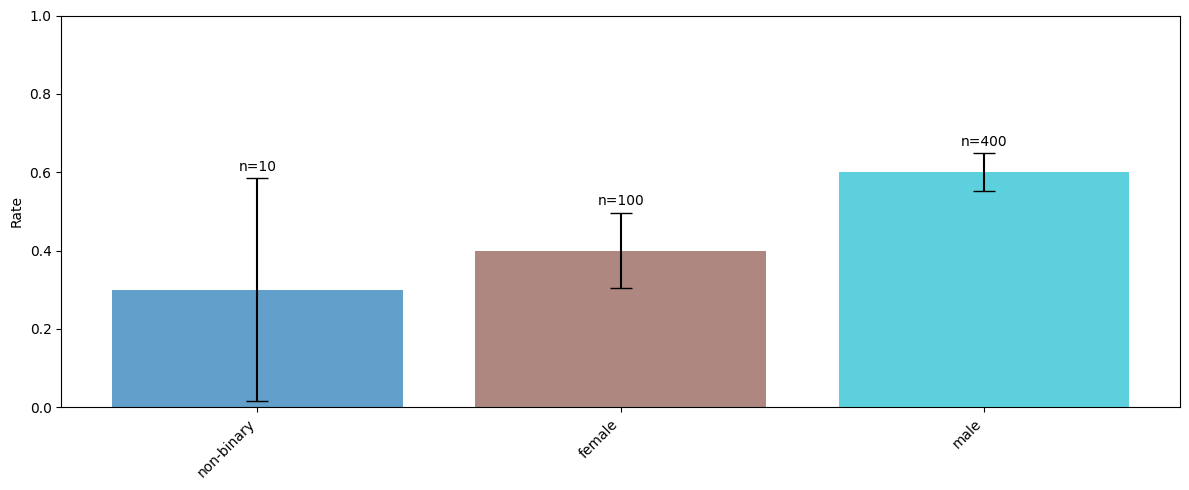

In [10]:
# As the fairness metrics are based on samples from data donation, reliability testing is important to help interpret the results.
# Here we provide an example of showing the accepted rate with confidence interval to help interpret demographic parity.

handler = MultipartyFairnessMeasurementMPYC(provider_id, data_handler)

# Suppose non-binary, female, male has accepted rate of 0.3, 0.4, 0.6
p = [0.3, 0.4, 0.6]

# This is the sample size of each group
n = [10, 100, 400]

# To visualize the accepted rate with confidence interval
handler._plot_confidence_intervals(p, n, labels=['non-binary', 'female', 'male'])

#higher n result in lower confidence intervals

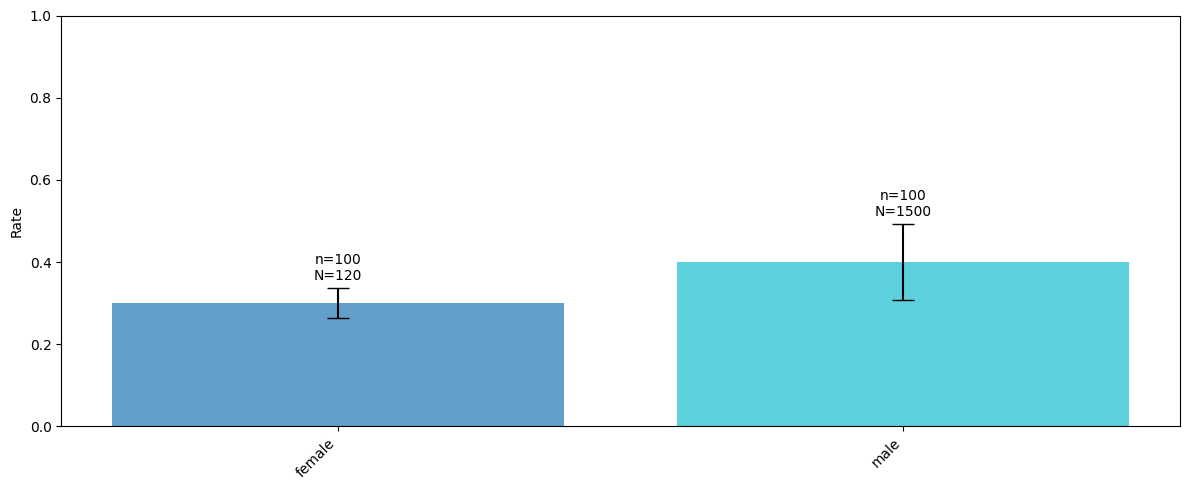

In [11]:
# Knowing the full size (N) of specific group can also facilitate the interpretation (e.g., n=100 among N=120 female candidates donate the data and compose the sample)
p = [0.3, 0.4]
n = [100, 100]
N = [120, 1500]

handler._plot_confidence_intervals(p, n, N, labels=['female', 'male'])
# a higher donation rate results in lower confidence intervals